In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb


from path_setup import setup_paths
setup_paths()

In [2]:
from dataset_transformer import BaseDatasetTransform
from base_model_train import BaseModelTrain
from model_evaluator import ModelEvaluator
from intelligence_tools import AnalyzeVariables

In [3]:
df = pd.read_csv('../datasets/healthcare-stroke-data.csv')

In [4]:
av = AnalyzeVariables(df)

In [5]:
av.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


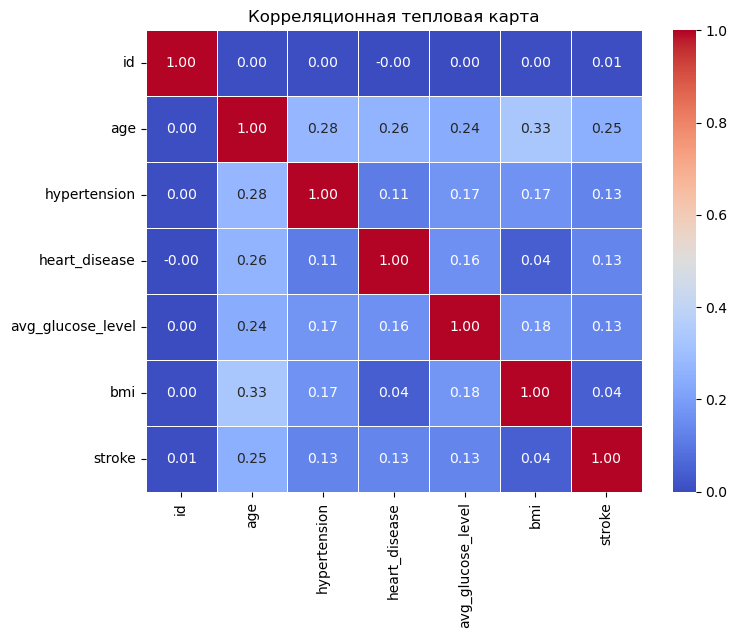

In [6]:
av.corr_heatmap()

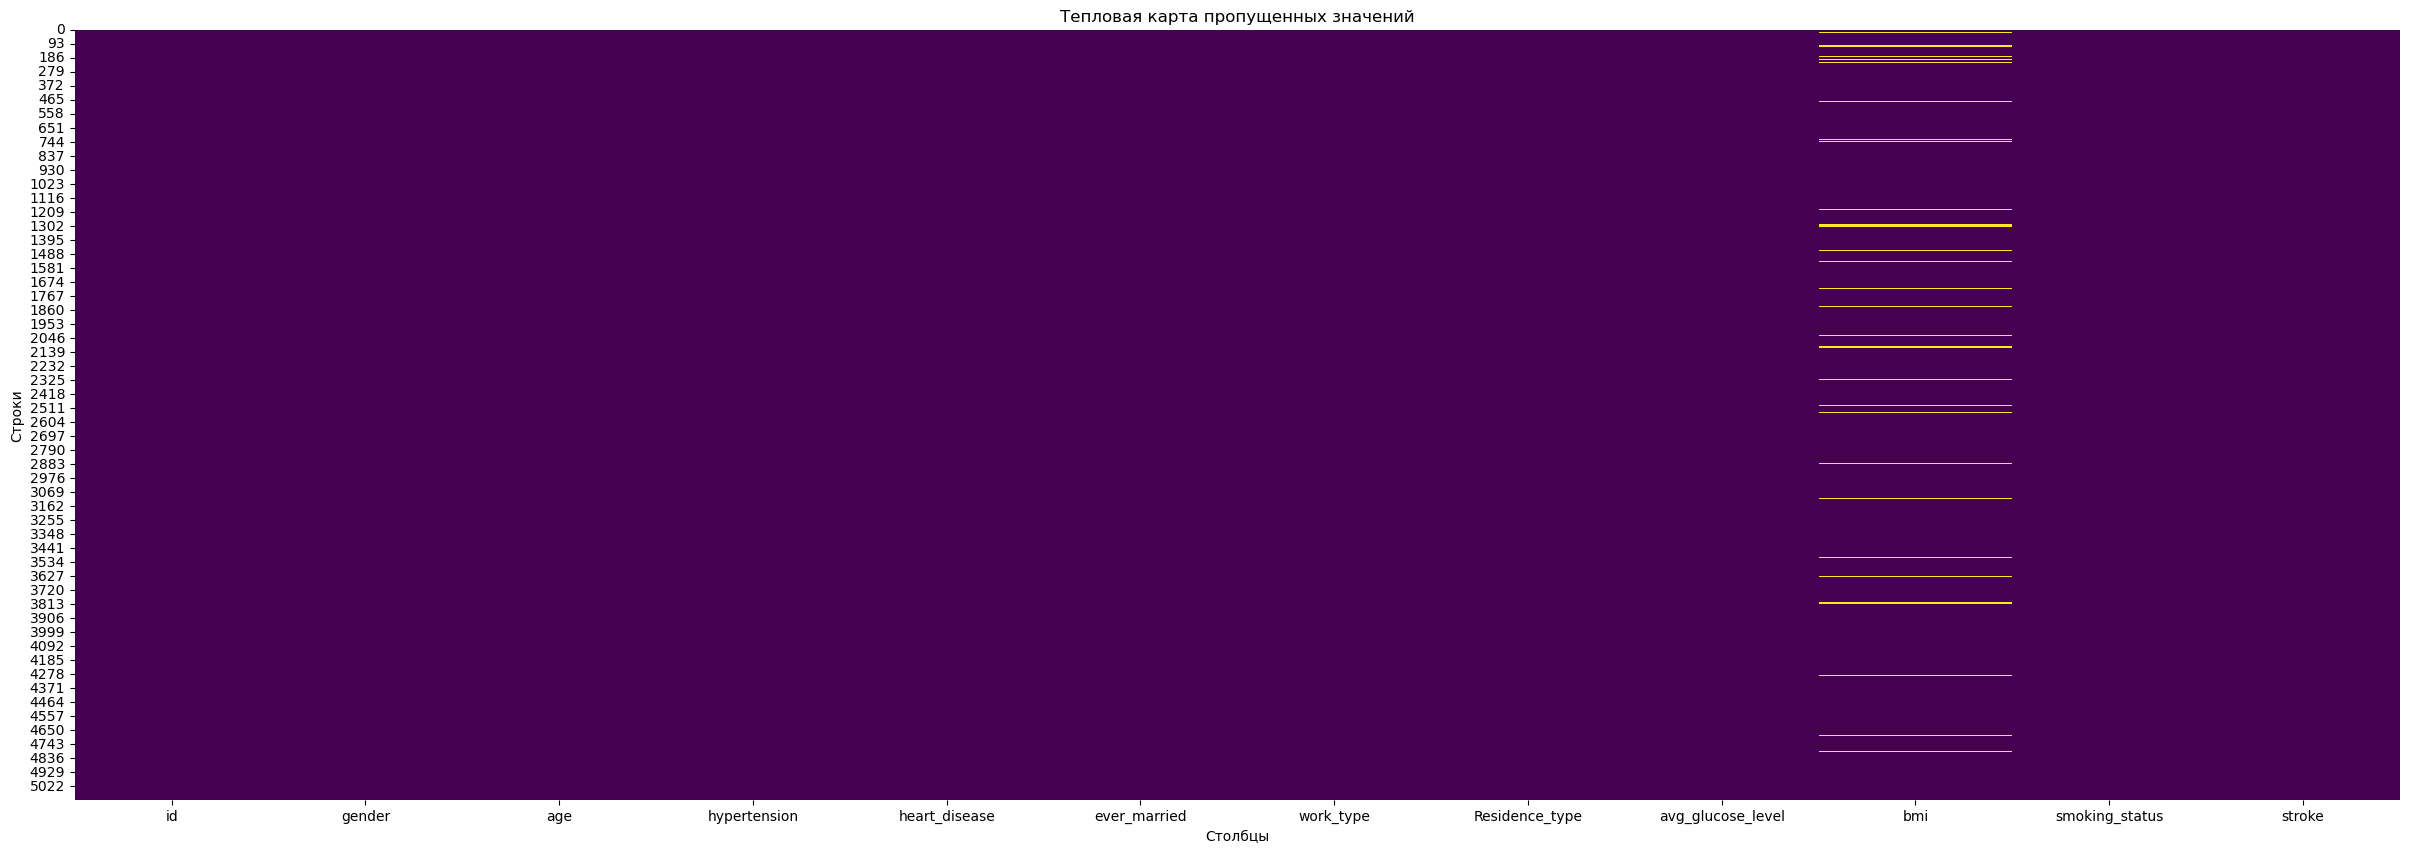

In [7]:
av.missing_heatmap()

In [8]:
bdf = BaseDatasetTransform(df,target='stroke')

In [9]:
X_train, X_test, y_train, y_test ,categorical_features = bdf.fit_transform()


Обнаружены колонки с именем "id": ['id', 'Residence_type']


Колонка "Residence_type" удалена.
Series([], dtype: int64)

В колонке(ах) ['stroke'] нет пропущенных значений
В наборе данных есть пропущенные значения:
Колонки с пропущенными значениями:
bmi    148
dtype: int64
Все пропущенные значения в обучающем наборе заполнены.
-------------------------------------------
Информация о колонках в датасете

Категориальные колонки:
Index(['gender', 'ever_married', 'work_type', 'smoking_status'], dtype='object')

Числовые колонки:
Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi'],
      dtype='object')


In [10]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

def preprocess_and_resample(X_train, y_train, X_test, categorical_cols, random_state=42):

    X_train_copy = X_train.copy()
    X_test_copy = X_test.copy()
    

    label_encoders = {col: LabelEncoder() for col in categorical_cols if col in X_train_copy.columns}
    
    for col, le in label_encoders.items():
        X_train_copy[col] = le.fit_transform(X_train_copy[col])
        X_test_copy[col] = le.transform(X_test_copy[col])

    smote = SMOTE(random_state=random_state)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_copy, y_train)

    X_train_resampled_df = pd.DataFrame(X_train_resampled, columns=X_train_copy.columns)
    X_test_processed_df = X_test_copy.copy()

    print("Shape of resampled X_train:", X_train_resampled_df.shape)
    print("Shape of processed X_test:", X_test_processed_df.shape)

    return X_train_resampled_df, y_train_resampled, X_test_processed_df




In [12]:

lgbm_model = lgb.LGBMClassifier(verbose=-1,is_balanced=True)

#lgbm_model = lgb.LGBMClassifier(verbose=-1)


columns_to_delete = []  


model_train = BaseModelTrain(
    model=lgbm_model,
    columns_to_delete=columns_to_delete,
    categorical_features=categorical_features,
    boosting_type='gbdt',
    objective='binary',
    metric='binary_error'
)

In [13]:
metrics = ['accuracy', 'balanced_accuracy_score','precision', 'recall', 'f1_macro']
evaluator = ModelEvaluator(model_trainer=model_train, metrics=metrics)

evaluator.fit(X_train, y_train)

c:\Users\Dmitriy.Burnashev\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Dmitriy.Burnashev\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


ModelEvaluator(metrics=['accuracy', 'balanced_accuracy_score', 'precision',
                        'recall', 'f1_macro'],
               model_trainer=BaseModelTrain(categorical_features=['gender',
                                                                  'ever_married',
                                                                  'work_type',
                                                                  'smoking_status'],
                                            columns_to_delete=[],
                                            model=LGBMClassifier(is_balanced=True,
                                                                 metric='binary_error',
                                                                 objective='binary',
                                                                 verbose=-1)))

In [14]:
evaluator.evaluate_to_dataframe(X_test, y_test)

,Metric,Score
0,accuracy,0.947162
1,precision,0.619487
2,recall,0.523237
3,f1,0.531340
